In [2]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from gensim.models import Word2Vec

In [3]:
"""

- Read in bootstrapped Cosine Similarity scores and preprocess for visualization
- For "sentiment" scores we average across all risk words and all advantage words 
to create a composite "Risk" or "Advantage" score for each bootstrap iteration.
- Then average across all boostrap iterations to get a final "Risk" and "Advantage" similarity score 
for each year.

"""


#define pos words, define neg words
negative_words = ['reputation', 'harm', 'liability', 'obligation', 'litigation', 'legislation']
positive_words = ['respect', 'invest', 'uphold', 'protect', 'empower', 'trust']

sentiment_df = pd.DataFrame(columns=['sentiment', 'mean_across_iterations', 'std_across_iterations', 'year'])

#generate sentiment level stats
for year in range(2010, 2023):

    #transform dataframe for grouped sentiment analysis
    results_df = pd.read_csv(f"RESULTS/{year}_results.csv").drop(columns=['Unnamed: 0'])
    results_df_pivoted = results_df.T.reset_index() #transpose dataframe
    results_df_pivoted.columns = ['word'] + list(range(50))  # 0-49 bootstrap iterations and the word   

    #assign words to negative and pos sentiment
    results_df_pivoted['sentiment'] = np.where(results_df_pivoted['word'].isin(negative_words), "negative", "positive")
    
    #get the average negative score and the average positive score for each iteration
    numeric_cols = [col for col in results_df_pivoted.columns if col not in ['word', 'sentiment']]
    summary_stats = results_df_pivoted.groupby('sentiment')[numeric_cols].mean()

    #convert yearly avg to dataframe
    sentiment_stats = pd.DataFrame({
    'mean_across_iterations': summary_stats.mean(axis=1),
    'std_across_iterations': summary_stats.std(axis=1),
    'year': year 
    }).reset_index()

    #concatenate to main dataframe with all years
    sentiment_df = pd.concat([sentiment_df, sentiment_stats])


sentiment_df.to_csv("FIGS/VIS_DATA/sentiment_analysis_data.csv", index=False)


/var/folders/r2/26wqb6z90xv49kpn_4dbtnfw0000gn/T/ipykernel_62489/4052058350.py:41: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  sentiment_df = pd.concat([sentiment_df, sentiment_stats])


In [4]:
"""

- Read in bootstrapped Cosine Similarity scores and preprocess for visualization 
- Then average across all boostrap iterations for each word to get a final, robust similarity score 
for each word, year pair.

"""

#define pos words, define neg words
negative_words = ['reputation', 'harm', 'liability', 'obligation', 'litigation', 'legislation']
positive_words = ['respect', 'invest', 'uphold', 'protect', 'empower', 'trust']

pos_words_df = pd.DataFrame(columns=['word', 'mean_across_iterations', 'std_across_iterations', 'year'])
neg_words_df = pd.DataFrame(columns=['word', 'mean_across_iterations', 'std_across_iterations', 'year'])

#generate sentiment level stats
for year in range(2010, 2023):

    #transform dataframe for grouped sentiment analysis
    results_df = pd.read_csv(f"RESULTS/{year}_results.csv").drop(columns=['Unnamed: 0'])
    results_df_pivoted = results_df.T.reset_index() #transpose dataframe
    results_df_pivoted.columns = ['word'] + list(range(50))  # 0-49 bootstrap iterations and the word   

    pos_results = results_df_pivoted[results_df_pivoted['word'].isin(positive_words)].set_index('word')
    neg_results = results_df_pivoted[results_df_pivoted['word'].isin(negative_words)].set_index('word')

    #convert yearly avg to dataframe
    pos_stats = pd.DataFrame({
    'mean_across_iterations': pos_results.mean(axis=1),
    'std_across_iterations': pos_results.std(axis=1),
    'year': year 
    }).reset_index()

    neg_stats = pd.DataFrame({
    'mean_across_iterations': neg_results.mean(axis=1),
    'std_across_iterations': neg_results.std(axis=1),
    'year': year 
    }).reset_index()

    #concatenate to main dataframe with all years
    pos_words_df = pd.concat([pos_words_df, pos_stats])
    neg_words_df = pd.concat([neg_words_df, neg_stats])


pos_words_df.to_csv("FIGS/VIS_DATA/positive_words_analysis_data.csv", index=False)
neg_words_df.to_csv("FIGS/VIS_DATA/negative_words_analysis_data.csv", index=False)


/var/folders/r2/26wqb6z90xv49kpn_4dbtnfw0000gn/T/ipykernel_62489/435532952.py:41: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pos_words_df = pd.concat([pos_words_df, pos_stats])
/var/folders/r2/26wqb6z90xv49kpn_4dbtnfw0000gn/T/ipykernel_62489/435532952.py:42: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  neg_words_df = pd.concat([neg_words_df, neg_stats])


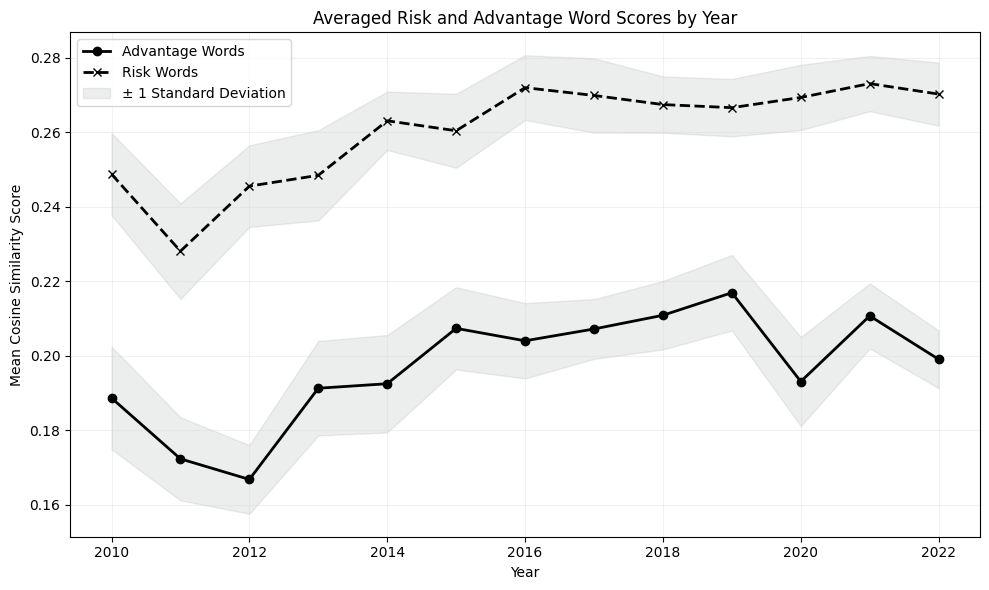

In [ ]:
"""

- plot the "sentiment" scores over time with +-1 st. dev shading. 
- used generatve AI to help plot results and format matplotlib

"""


# read in data
df = pd.read_csv("FIGS/VIS_DATA/sentiment_analysis_data.csv")

plt.figure(figsize=(10, 6))

linestyles = {'positive': '-', 'negative': '--'}
markers = {'positive': 'o', 'negative': 'x'}

#loop through sentiments 
for sentiment in ['positive', 'negative']:
    data = df[df['sentiment'] == sentiment].sort_values('year')#filter dataframe
    
    upper = data['mean_across_iterations'] + data['std_across_iterations']
    lower = data['mean_across_iterations'] - data['std_across_iterations']
    
    #plot the line in black
    plt.plot(data['year'], data['mean_across_iterations'], 
             label='Risk Words' if sentiment == 'negative' else 'Advantage Words', 
             marker=markers[sentiment], 
             linewidth=2, 
             color='black',
             linestyle=linestyles[sentiment])
    
    # if statement to make sure we print st dev bar once in legend
    if sentiment == 'negative':
        # Add shaded region in gray
        plt.fill_between(data['year'], lower, upper, 
                        color="#a2a9a8", 
                        alpha=0.2, 
                        label="± 1 Standard Deviation")
    else:
        # Add shaded region in gray
        plt.fill_between(data['year'], lower, upper, 
                        color="#a2a9a8", 
                        alpha=0.2)


plt.xlabel('Year')
plt.ylabel('Mean Cosine Similarity Score')
plt.title('Averaged Risk and Advantage Word Scores by Year')
plt.legend()
plt.grid(True, alpha=0.3, color='lightgray')
plt.tight_layout()
plt.show()

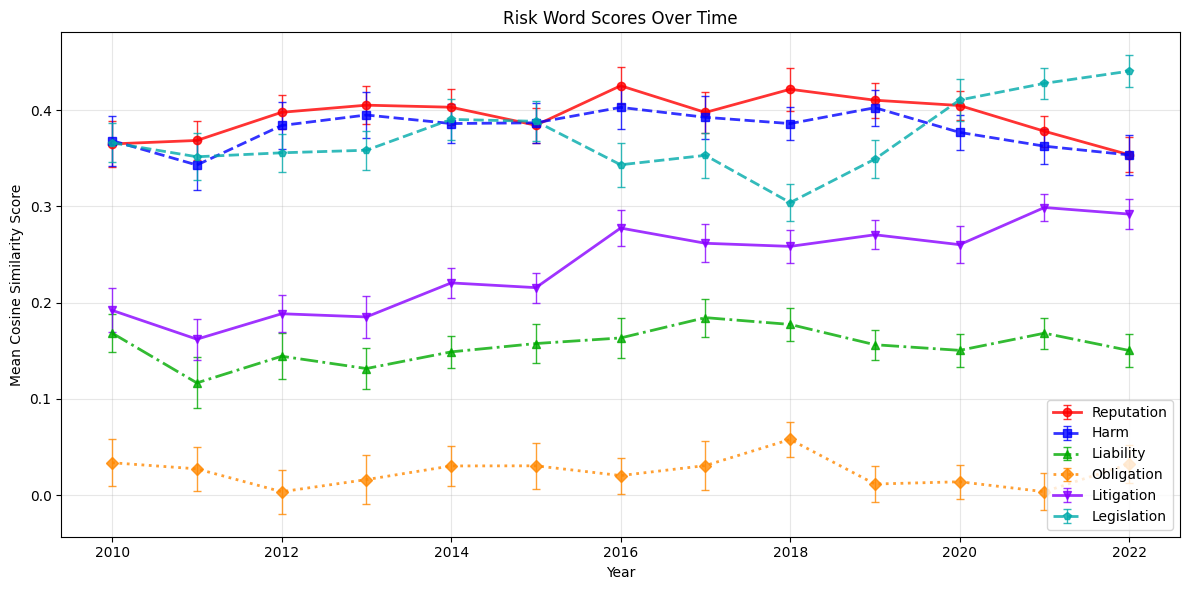

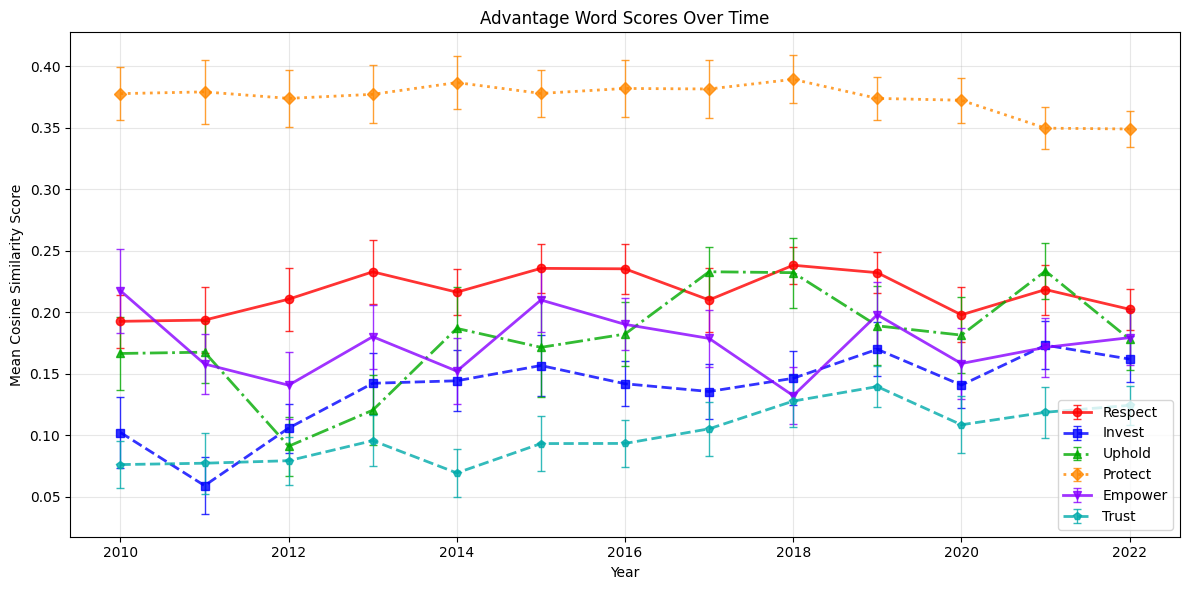

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

#read the data
pos_data = pd.read_csv('FIGS/VIS_DATA/positive_words_analysis_data.csv')
neg_data = pd.read_csv('FIGS/VIS_DATA/negative_words_analysis_data.csv')

#contrast colors for words + varied line/marker styles
colors = ['#FF0000', '#0000FF', '#00AA00', '#FF8800', '#8800FF', '#00AAAA']  # Red, Blue, Green, Orange, Purple, Teal
linestyles = ['-', '--', '-.', ':', '-', '--']
markers = ['o', 's', '^', 'D', 'v', 'p']

#plot negative words first
plt.figure(figsize=(12, 6))

#loop through each of the risk words
for i, word in enumerate(['reputation', 'harm', 'liability', 'obligation', 'litigation', 'legislation']):
    data = neg_data[neg_data['word'] == word].sort_values('year')
    
    #plot line, looping through various markers and colors for each different word
    plt.errorbar(data['year'], data['mean_across_iterations'],
                yerr=data['std_across_iterations'],
                label=word.title(),
                marker=markers[i],
                linewidth=2,
                color=colors[i],
                linestyle=linestyles[i],
                capsize=3,
                capthick=1,
                elinewidth=1,
                alpha=0.8,
                ecolor=colors[i],
                errorevery=1)

plt.xlabel('Year')
plt.ylabel('Mean Cosine Similarity Score')
plt.title('Risk Word Scores Over Time')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

#plot positive words now
plt.figure(figsize=(12, 6))

#loop through positive words
for i, word in enumerate(['respect', 'invest', 'uphold', 'protect', 'empower', 'trust']):
    data = pos_data[pos_data['word'] == word].sort_values('year')
    
    #plot line, looping through various markers and colors for each different word
    plt.errorbar(data['year'], data['mean_across_iterations'],
                yerr=data['std_across_iterations'],
                label=word.title(),
                marker=markers[i],
                linewidth=2,
                color=colors[i],
                linestyle=linestyles[i],
                capsize=3,
                capthick=1,
                elinewidth=1,
                alpha=0.8,
                ecolor=colors[i],
                errorevery=1)

plt.xlabel('Year')
plt.ylabel('Mean Cosine Similarity Score')
plt.title('Advantage Word Scores Over Time')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
#keep track of most similar words to privacy over the years
for year in range(2010, 2023):

    model = Word2Vec.load(f'BASE_MODELS/base_model_{year}.model') #load model

    similar_words = pd.DataFrame(model.wv.most_similar(['privacy'], topn=5)) #get most similar words

    similar_words['year'] = year 

    similar_words.rename(columns={0:'word', 1:'cosine_similarity'})

    similar_words.to_csv(f'RESULTS/{year}_privacy_top_n.csv') #write to dataframe
